In [ ]:
import os
import shutil
from pathlib import Path

import pandas as pd
import numpy as np

from validation_utils import (
    get_inchikey_from_smiles,
    get_pachqa_structures,
    get_rmsd_between_two_molecules,
)

In [ ]:
# path to folder with `summary.csv` and `structures` from https://libdrive.ethz.ch/index.php/s/X5vOBNSITAG5vzM
QMUGS_SOURCE_FOLDER = Path("qmugs").absolute()

# path to folder with props.csv
PACHQA_SOURCE_FOLDER = Path("../property_parsing/").absolute()

# path to PACHQA structures
PACHQA_STRUCTURES_SOURCE_FOLDER = Path("data").absolute()

# output files will be writen here
TMP_DIR = Path("tmp_qmugs/").absolute()

In [ ]:
if not TMP_DIR.exists():
    os.makedirs(TMP_DIR)

## Reading PACHQA data

In [ ]:
pachqa_data = pd.read_csv(Path(PACHQA_SOURCE_FOLDER, "props.csv"))
pachqa_data = pachqa_data[pachqa_data.level == "xtb2"]
pachqa_inchikeys = set(pachqa_data.key)

## Reading QMUGS data and merging molecules by InChIKey

In [ ]:
PUBLIC_NAMES = {
    "summary.csv": "QMUGS",
}

EXTRACTABLE_COLUMNS = [
    "DFT_DIPOLE_TOT",
    "DFT_HOMO_ENERGY",
    "DFT_HOMO_LUMO_GAP",
    "DFT_LUMO_ENERGY",
    "DFT_TOTAL_ENERGY",
    "GFN2_DIPOLE_TOT",
    "GFN2_ENTROPY_TOT",
    "GFN2_FORMATION_ENERGY",
    "GFN2_HOMO_ENERGY",
    "GFN2_HOMO_LUMO_GAP",
    "GFN2_LUMO_ENERGY",
    "GFN2_POLARIZABILITY_MOLECULAR",
    "GFN2_TOTAL_ENERGY",
    "GFN2_TOTAL_ENTHALPY",
    "GFN2_TOTAL_FREE_ENERGY",
    "smiles",
    "conf_id",
    "chembl_id",
]

In [ ]:
for filepath in QMUGS_SOURCE_FOLDER.glob("*.csv"):
    if filepath.name not in PUBLIC_NAMES:
        continue
    print(f"Starting to merge {filepath.name} with PACHQA results")
    qmugs_data = pd.read_csv(filepath)
    qmugs_data = qmugs_data[qmugs_data.conf_id == "conf_02"]
    for column in qmugs_data.columns:
        if column not in EXTRACTABLE_COLUMNS:
            qmugs_data.drop(columns=column, inplace=True)
    qmugs_data["key"] = qmugs_data.smiles.map(get_inchikey_from_smiles)
    matched_data = pd.merge(
        pachqa_data, qmugs_data, on="key", suffixes=("_pachqa", "_qmugs")
    )
    print(
        f"There are {matched_data.shape[0]} rows with matching InChIKey and {len(set(matched_data.key))} unique InChIKeys"
    )
    matched_data.to_csv(Path(TMP_DIR, filepath.name + "_matched.csv"), index=False)

## Calculating heavy atom RMSD for the molecules from two datasets

### Preparing geometry data

In [ ]:
KEY_STRUCTURE_COLUMN_MAPPED = {
    "summary.csv": "chembl_id",
}

KEY_UNPACK_FORMAT_MAPPED = {
    "summary.csv": "folder",
}

SUPPORTED_TYPES = (
    "xyz",
    "sdf",
)

for filepath in QMUGS_SOURCE_FOLDER.glob("*.csv"):
    if filepath.name not in PUBLIC_NAMES:
        continue
    matched_data = pd.read_csv(Path(TMP_DIR, filepath.name + "_matched.csv"))
    name = KEY_STRUCTURE_COLUMN_MAPPED[filepath.name]
    base_path = filepath.parent
    structures_path = Path(base_path, filepath.name + "_structures")
    assert name in matched_data.columns

    extract_dest = Path(TMP_DIR, filepath.name + "_structures")
    if any(matched_data[name]) and not extract_dest.exists():
        extract_dest.mkdir()

    unpack_format = KEY_UNPACK_FORMAT_MAPPED[filepath.name]
    if unpack_format == "folder":
        for structure_name, structure_conf_id, structure_inchikey in matched_data[
            [name, "conf_id", "key"]
        ].values:
            for structure_type in SUPPORTED_TYPES:
                structure_path = Path(
                    structures_path,
                    structure_name,
                    structure_conf_id + "." + structure_type,
                )
                if structure_path.exists():
                    shutil.copyfile(
                        structure_path,
                        Path(
                            extract_dest,
                            structure_inchikey
                            + "_"
                            + structure_conf_id
                            + "."
                            + structure_type,
                        ),
                    )
                    break
            else:
                exception = Exception("Cannot find structure.")
                exception.add_note(f"Dataset path: {filepath}")
                exception.add_note(f"Structure name: {structure_name}")
                raise exception
    else:
        raise ValueError("No such unpack format")

### Calculating RMSD

In [ ]:
INCHIKEY_STRUCTURES_MAPPED = get_pachqa_structures(PACHQA_STRUCTURES_SOURCE_FOLDER)
SUPPORTED_TYPES = (
    "xyz",
    "sdf",
)

for filepath in TMP_DIR.glob("*_matched.csv"):
    matched_data = pd.read_csv(filepath)
    if filepath.name.count("_matched.csv") > 1:
        raise Exception(
            "Something wrong. There is more than one `_matched.csv`."
        )
    qmugs_structures_path = Path(
        filepath.parent, filepath.name.replace("_matched.csv", "") + "_structures"
    )
    dump_pairs_path = Path(
        filepath.parent, filepath.name.replace("_matched.csv", "") + "_pairs"
    )

    if not dump_pairs_path.exists():
        dump_pairs_path.mkdir()

    rmsd_xtb2 = []
    rmsd_r2scan = []
    rmsd_mmff94 = []

    for inchikey, structure_conf_id in matched_data[["key", "conf_id"]].values:
        pachqa_structures_path = INCHIKEY_STRUCTURES_MAPPED[inchikey]
        for qmugs_structure_type in SUPPORTED_TYPES:
            qmugs_structure_path = Path(
                qmugs_structures_path,
                inchikey + "_" + structure_conf_id + "." + qmugs_structure_type,
            )
            if qmugs_structure_path.exists():
                break
        else:
            raise Exception(
                f"There are no structures for InChIKey {inchikey} and conf_id {structure_conf_id} in {filepath.name}"
            )

        pachqa_mol_path_sdf_ref = Path(pachqa_structures_path, "pubchem_conf.sdf")

        pachqa_mol_path_xyz_xtb2 = Path(pachqa_structures_path, "xtb2.xtbopt.xyz")
        rmsd_xtb2.append(
            get_rmsd_between_two_molecules(
                file1=pachqa_mol_path_xyz_xtb2,
                file2=qmugs_structure_path,
                ref=pachqa_mol_path_sdf_ref,
                dump=True,
                dump_name=Path(
                    dump_pairs_path, "xtb2_" + inchikey + "_" + structure_conf_id
                ),
            )
        )

    matched_data["rmsd_xtb2"] = rmsd_xtb2
    matched_data.to_csv(Path(filepath.parent, filepath.name + "_rmsd.csv"), index=False)

### Plotting RMSD

In [ ]:
from matplotlib import pyplot as plt

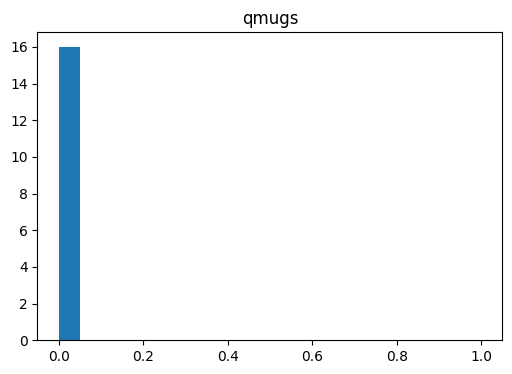

In [ ]:
MERGE_RMSD_HIST = {
    "summary.csv_matched.csv_rmsd.csv": "qmugs",
}

rmsd_hist = {}

for filepath in TMP_DIR.glob("*_rmsd.csv"):
    if filepath.name.count("_rmsd.csv") > 1:
        raise Exception("Something wrong. There is more than one `_matched.csv`.")
    if filepath.name not in MERGE_RMSD_HIST:
        continue
    merged_name = MERGE_RMSD_HIST[filepath.name]
    rmsd_hist[merged_name] = rmsd_hist.get(merged_name, [])
    compas_rmsd_data = pd.read_csv(filepath)
    for rmsd_xtb2 in compas_rmsd_data.rmsd_xtb2:
        rmsd_hist[merged_name].append(rmsd_xtb2)

for rmsd_hist_key in rmsd_hist:
    plt.figure(figsize=(6, 4))
    plt.title(rmsd_hist_key)
    plt.hist(rmsd_hist[rmsd_hist_key], bins=np.arange(0, 1 + 1e-10, 0.05))